In [105]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
import numpy as np

# run this with the help of 
# $ docker run --rm -it -p 8882:8888 -v "$PWD":/tf/lec tensorflow/tensorflow:2.0.0a0-py3-jupyter

# Autoencoders

An autoencoder is a model which applies a series of functons to reduce an input sample to a low-dimensional representation. Then the same model applies a _different_ series of functions to convert the low-dimensional representation back into the same dimensionality as the original sample.

* The first step "compresses" the sample into a smaller form.
* The second step "paints" a higher dimensional sample from the compressed form.

With a standard autoencoder, we try to find compression and decompression models which simply result in the original image.

## Advantages

### Data compression

We'll see in the following example, it is sometimes possible to compress a largeish amount of information (e.g., a 784-pixel image of hand-drawn digits) into a 2-dimensional vector, for a **99.7% space savings**. The only downside is that you have to ship the decoding half of the model with the compressed data.

### Other advantages

* Denoising
* Data generation
* Feature generation
* Data exploration

which we'll explore in the following example

## Example

Let's use a stack of dense layers to autoencode the MNIST dataset.


In [280]:
# grab the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# autoencoding is an unsupervised process, so we can use the test data to train!
x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))

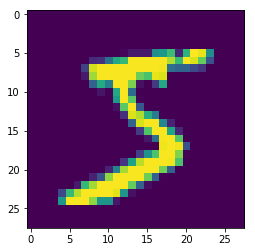

In [281]:
# assure ourselves it's real
plt.imshow( x_train[0] )

In [282]:
# smoosh each image into a row in a matrix
X_train = x_train.reshape(len(x_train),-1)

The autoencoder is as straightforward as a can be:

#### Encoding step
* The 784-pixel input is used as an input for 128 neurons in the first layer.
* The activations all 128 neurons are densely connected to 64 neurons.
* The output of these 64 neurons are linearly mapped to **two units**

#### Decoding step
* The two units are densely connected to 64 neurons
* Which are densely connected to 128 neurons
* Which are densely linearly mapped to 784 output units.

In [283]:
model2 = tf.keras.models.Sequential()
model2.add(Dense(128,  activation='relu', input_shape=(784,)))
model2.add(Dense(64,  activation='relu'))
model2.add(Dense(2,    activation='linear', name="bottleneck"))
model2.add(Dense(64,  activation='relu'))
model2.add(Dense(128,  activation='relu'))
model2.add(Dense(784,  activation='linear'))
model2.compile(loss='mean_squared_error', optimizer = 'adam')

In [284]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 130       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 784)               101136    
Total params: 218,514
Trainable params: 218,514
Non-trainable params: 0
________________________________________________

The resulting model has about a quarter million parameters, which should be enough to do something interesting.

In [285]:
history = model2.fit(X_train.astype(float), X_train.astype(float),
                     batch_size=128,
                     epochs=100)

Epoch 1/100
70000/70000 [==============================] - 7s 96us/sample - loss: 3472.6971
Epoch 2/100
70000/70000 [==============================] - 7s 106us/sample - loss: 3026.9758
Epoch 3/100
70000/70000 [==============================] - 7s 98us/sample - loss: 2911.8788
Epoch 4/100
70000/70000 [==============================] - 8s 112us/sample - loss: 2840.4237
Epoch 5/100
70000/70000 [==============================] - 8s 111us/sample - loss: 2798.6447
Epoch 6/100
70000/70000 [==============================] - 6s 91us/sample - loss: 2770.1173
Epoch 7/100
70000/70000 [==============================] - 7s 104us/sample - loss: 2745.1584
Epoch 8/100
70000/70000 [==============================] - 6s 91us/sample - loss: 2725.2353
Epoch 9/100
70000/70000 [==============================] - 8s 113us/sample - loss: 2709.9090
Epoch 10/100
70000/70000 [==============================] - 7s 107us/sample - loss: 2696.8986
Epoch 11/100
70000/70000 [==============================] - 8s 109us/samp

After a 100 epochs, the train loss continues to drop. This is a feature of models with very large numbers of parameters. Often, a large fraction of the parameters aren't contributing at all, and the gradient is descending most quickly for a small fraction of parameters whose improvement contributes most greatly to the reduction of loss. Then, once those parameters have "bottomed out", the gradient will go and look for other parameters to improve.

In the first stage of gradient descent for large models, the parameters are learned "all at once". But in the following stage, the unused parameters drift towards being used once at a time.

It's sort of like childhood. When you're a baby, you quickly improve a huge number of skills at once from nonexistent to passable. As you get older, you switch to focusing on one thing at a time until you plateau at the level of effort you're interested in devoting to that one thing, and then move on to acquiring the next skill.

Text(0.5, 0, 'epoch')

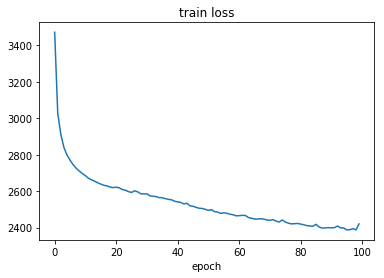

In [333]:
plt.title("train loss")
plt.plot( history.history["loss"] )
plt.xlabel("epoch")

Let's peek at a few digits and their autoencoded and reconstructed selves.

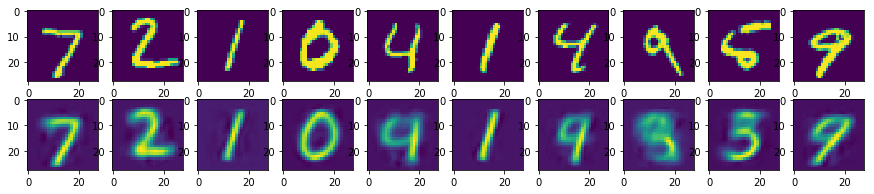

In [368]:
im_i=15

fig, axs = plt.subplots(2,10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow( X_test[i:i+1].reshape(28,28) )
    axs[1][i].imshow( model2.predict( X_test[i:i+1] ).reshape(28,28) )

## Autoencoding as dimensionality reduction

The output of the bottleneck step can be considered a dimensionality reduction of the original samples. Because the bottleneck layer in this autoencoder has 2 units, we can plot the 2-dimensional output on a scatter plot.

In [369]:
layer_outputs = [X_test]
for layer in model2.layers:
    layer_outputs.append( layer( layer_outputs[-1] ) )

In [370]:
for i, ll in enumerate( layer_outputs ):
    print( "layer {} -- shape {}".format(i+1, ll.shape) )

layer 1 -- shape (10000, 784)
layer 2 -- shape (10000, 128)
layer 3 -- shape (10000, 64)
layer 4 -- shape (10000, 2)
layer 5 -- shape (10000, 64)
layer 6 -- shape (10000, 128)
layer 7 -- shape (10000, 784)


In [371]:
autoencoded = layer_outputs[3].numpy()

Text(0.5, 1.0, 'auto-encoded MNIST digits')

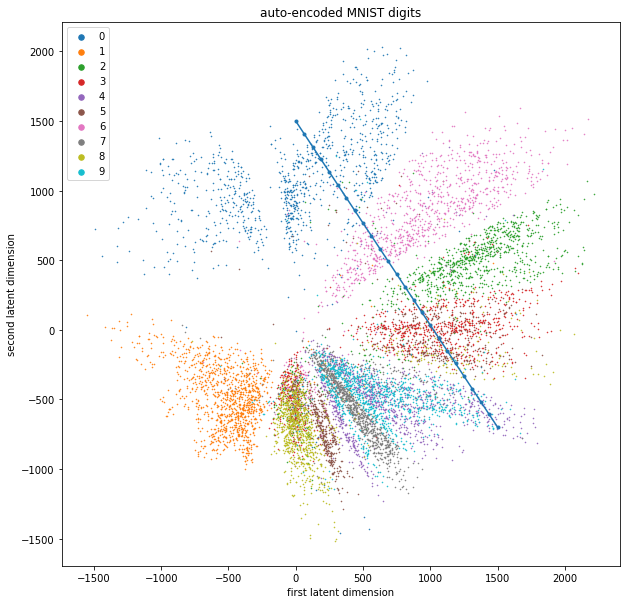

In [372]:
fig, ax = plt.subplots( figsize=(10,10) )

x0, y0 = 0, 1500
x1, y1 = 1500, -700
x_walk = np.linspace(x0, x1, 25)
y_walk = np.linspace(y0, y1, 25)
ax.plot(x_walk,y_walk, ".-")

for i in range(10):
    mask = (y_test==i)
    ax.scatter( *autoencoded[mask].T, s=0.3, label=str(i) )
ax.legend(markerscale=10)
ax.set_xlabel("first latent dimension")
ax.set_ylabel("second latent dimension")
ax.set_title("auto-encoded MNIST digits")



## Autoencoder as data generator

The latter half of the model stack takes encodings and generates images from them. So if we want, we could take a walk across the 2d space of MNIST encodings and look at the corresponding images:

In [325]:
compressed_nums = np.stack( [x_walk, y_walk] ).T

In [326]:
decompressed_imgs = invmodel( compressed_nums ).numpy().reshape(25, 28, 28)

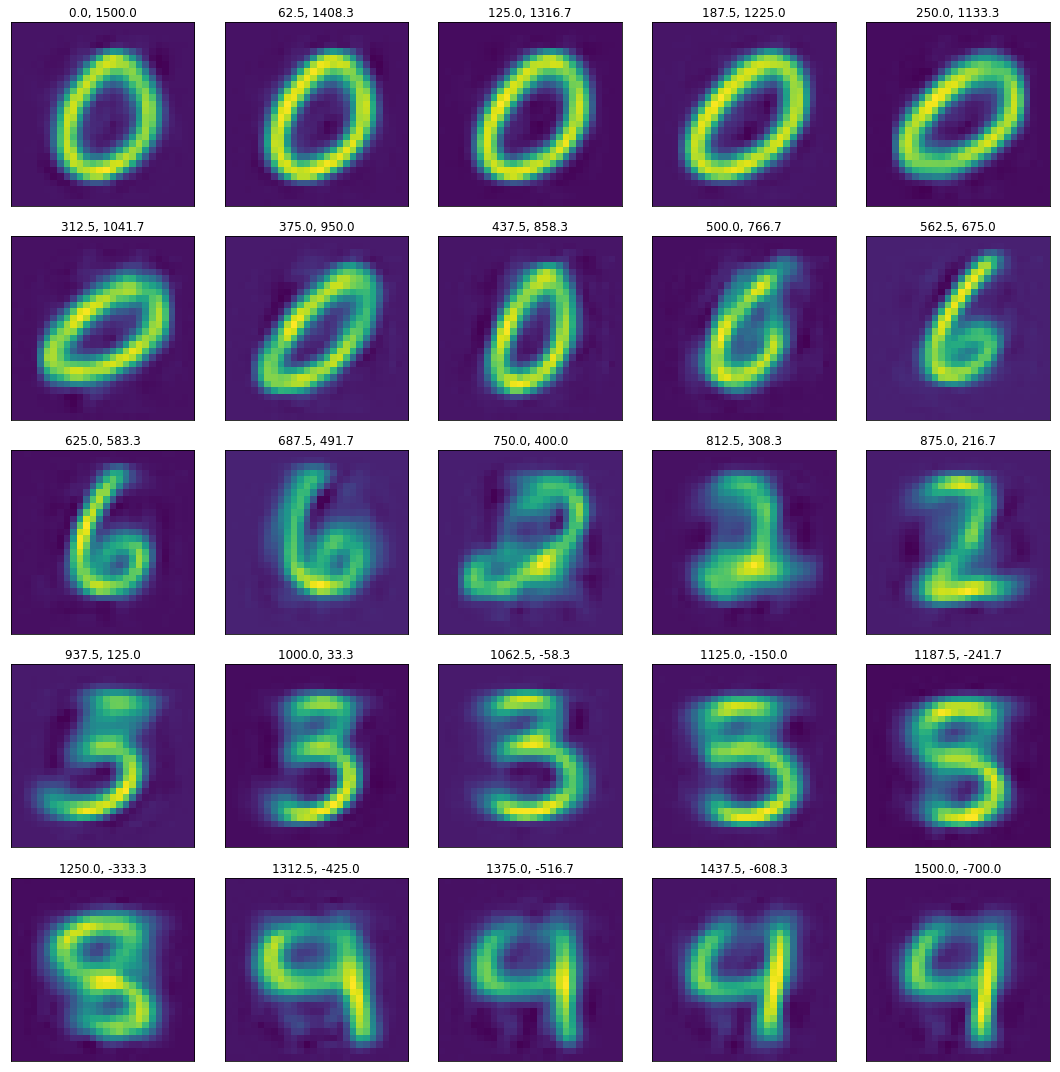

In [327]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))
axs = axs.flatten()
for i in range(25):
    ax = axs[i]
    ax.imshow( decompressed_imgs[i] )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("{:0.1f}, {:0.1f}".format(*compressed_nums[i]))
fig.tight_layout()

## Autoencoders as data exploration and explanation

The last densely connected layer is represented by 128-by-784 matrix. You can view this as 128 "images", which are combined by a weighted sum using the input from the 128 units in the previous layers.

In [381]:
# neuron activations output by second-to-last layer, with 128 units
feature_activation = layer_outputs[-2].numpy()[0]
feature_activation

array([  0.       ,   0.       ,  89.775955 ,  19.918133 ,   0.       ,
         0.       ,  11.67288  ,   0.       ,   0.       ,   0.       ,
       102.84454  ,  21.279741 ,  44.518353 ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       , 131.25055  ,   0.       ,
         3.563221 ,   0.       ,   0.       ,   0.       ,   0.       ,
        52.346344 ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       , 208.29518  ,  15.947783 ,
         0.       ,   0.       ,   0.       ,   0.       , 107.23859  ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,  28.174595 ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,  93.97208  ,   0.       ,
       117.2011   ,   0.       ,  10.54851  ,   0.       ,   0.       ,
         0.       , 176.4224   ,   0.       , 119.79792  ,   6.9126744,
         0.       ,   0.       ,   0.       ,   9.583264 , 188.8

Here's an arbitrary sample of the 100 rows from the weights matrix in the final layer, reshaped into image form:

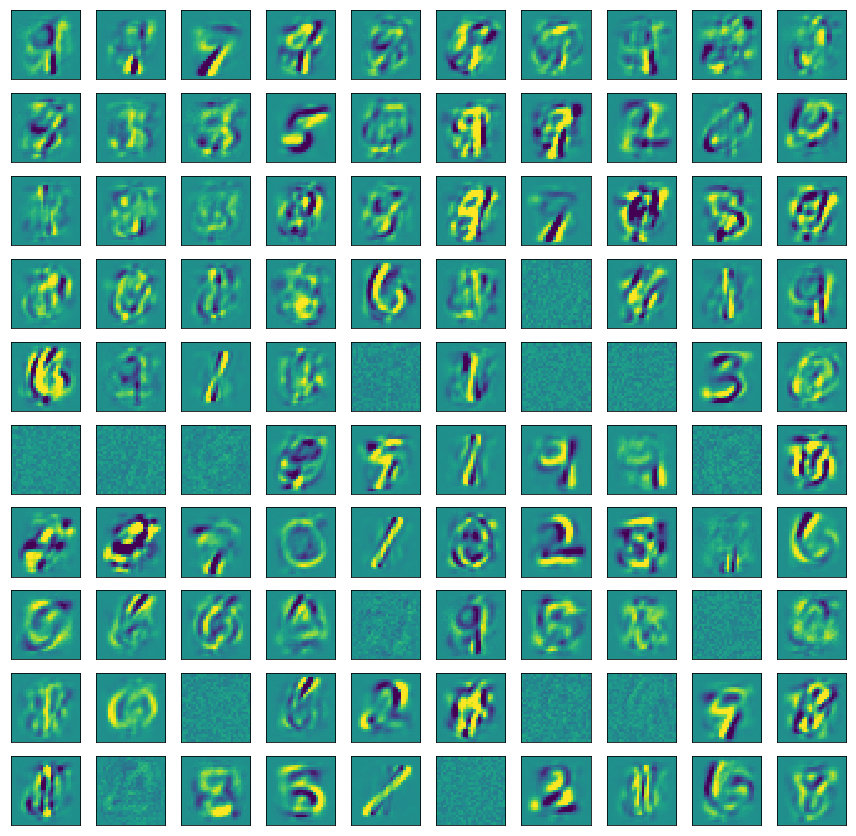

In [391]:
W, b = model2.layers[-1].get_weights()

relevant_features = feature_activation.argsort()[::-1][0:100]

W_relevant = W[ relevant_features ]

fig, axs = plt.subplots(10,10, figsize=(15,15))
axs = axs.flatten()
for i in range(100):
    ax = axs[i]
    ax.imshow( W_relevant[i].reshape(28,28), vmin=-0.5, vmax=0.5 )
    ax.set_xticks([])
    ax.set_yticks([])

In a simlar way to "eigenfaces", you can build up a digit from the "eigendigits" stored in the rows of the weights matrix in the last layer.

It seems that the most relevant "eigendigits" are basically stroke components.

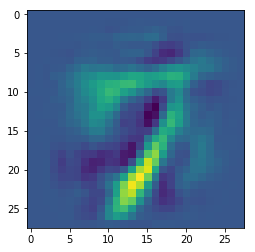

In [412]:
rel_activation = feature_activation[ relevant_features[0:10] ][None, :]
W_most_relevant = W_relevant[0:10]
plt.imshow( (rel_activation @ W_most_relevant).reshape(28,28) )